Se importa pachetele necesare implementarii

In [16]:
import cv2 
import sys
import os
import skimage
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFilter 
import skimage.filters
from skimage import io, filters
import matplotlib.pyplot as pl



Se creeaza o functie pentru incarcarea unei imagini de fund de ochi color. Initial, se verifica daca fisierul se gaseste in calea specificata sau daca
calea respectiva exista, iar daca nu, se arunca o exceptie de tip FileNotFoundError(), apoi se verifica daca imaginea s-a incarcat, iar daca nu, se arunca o exceptie de tip ValueError(). Daca totul este bine, se returneaza imaginea incarcata.


In [17]:
def load_image(path_image):
    if not os.path.exists(path_image):
        raise FileNotFoundError("Calea catre imagine nu este corecta, fisierul nu a fost gasit!")
        
    image = cv2.imread(path_image)
    
    if image is None:
        raise ValueError("Eroare in incarcarea imaginii!")
    return image

Se utilizeaza un bloc try..except pentru a prinde eventualele erori care pot aparea in timpul incarcarii imaginii.
Am facut conversia BGR to RGB cu ajutorul functiei cvtColor(), deoarece biblioteca CV foloseste canalele de culoare in ordinea BGR pentru a reprezenta imaginile.


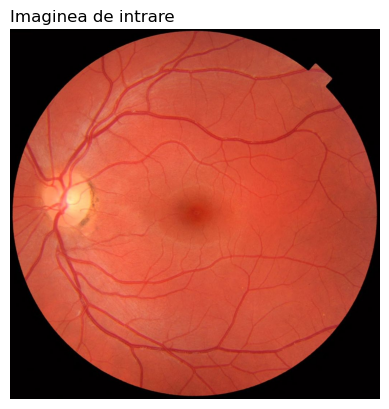

In [18]:
# specificarea căii către imagine
image_path = 'C:/Users/Denisa/Desktop/image.jpg' 

try:
    # se incarca imaginea
    loaded_image = load_image(image_path)
    
    # conversia din BGR în RGB
    loaded_image_converted = cv2.cvtColor(loaded_image, cv2.COLOR_BGR2RGB)  
    
    plt.figure()
    plt.title('Imaginea de intrare', loc='left')
    plt.axis('off')
    plt.imshow(loaded_image_converted)  # se adauga imaginea in figura
    plt.show()  # se afiseaza efectiv imaginea pe ecran

except Exception as e:
    print(e)  # se afiseaza posibilele erori
    

Se utilizeaza canalul verde in reprezentarea imaginii deoarece studiile au aratat ca in cazul vaselor de sange folosirea acestuia
este mai eficienta pentru detectie.
Imaginea este reprezentata de asemenea pe nivele de gri.

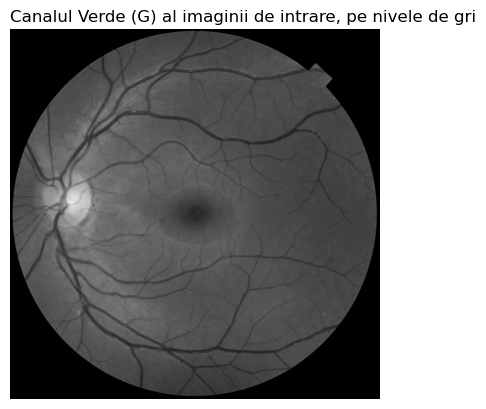

In [19]:
loaded_image_converted_g = loaded_image_converted[:,:,1]; # extragerea canalului verde
plt.figure()
plt.imshow(loaded_image_converted_g, cmap = 'gray', vmin=0, vmax=256)
plt.title('Canalul Verde (G) al imaginii de intrare, pe nivele de gri',loc='left')
plt.axis('off')
plt.show()

Se defineste o functie numita preprocess_image, in interiorul careia se aplica CLAHE (Contrast Limited Adaptive Histogram Equalization) pe imaginea de intrare pentru a îmbunătăți contrastul.
ClipLimit=2.0: controlează gradul de contrast; o valoare mai mare aplică un contrast mai puternic.
TileGridSize=(8, 8): imparte imaginea în blocuri de 8x8 pixeli pentru a aplica CLAHE adaptiv în fiecare regiune.
Rezultatul acestei funcții este o imagine în tonuri de gri cu un contrast mai ridicat în zonele unde detaliile erau mai dificil de observat.

In [20]:

def preprocess_image(loaded_image_converted_g):
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(loaded_image_converted_g)

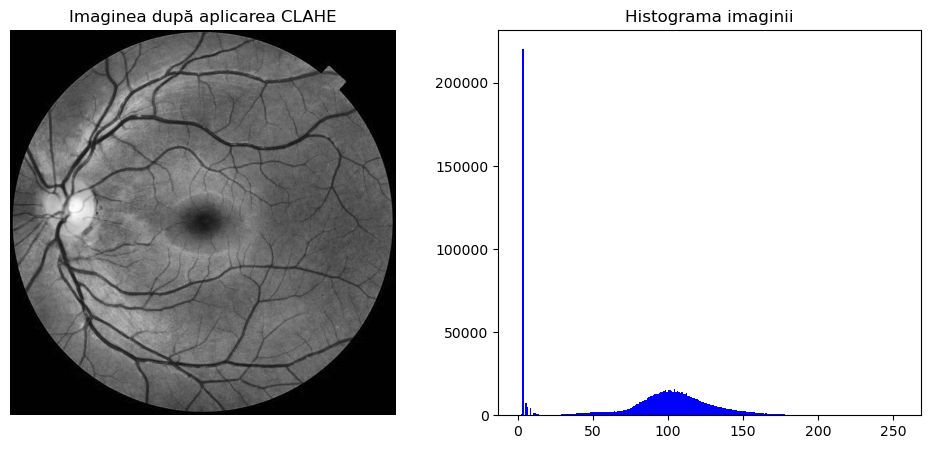

In [21]:
# Aplicarea preprocesării pe imagine
preprocessed_image = preprocess_image(loaded_image_converted_g)

# Afișarea imaginii preprocesate după aplicarea CLAHE
plt.figure(figsize=(12, 5))

# afișarea imaginii 
plt.subplot(1, 2, 1)
plt.imshow(preprocessed_image, cmap='gray')
plt.title("Imaginea după aplicarea CLAHE")
plt.axis('off')  # Eliminarea axelor

# afișarea histogramei imaginii
plt.subplot(1, 2, 2)
plt.hist(preprocessed_image.ravel(),256,[0, 256], color='blue')
plt.title("Histograma imaginii")
plt.show()

In continuare, este folosita filtrarea Gaussiana care este un filtru de netezire care aplică un kernel Gaussian pe o imagine pentru a atenua zgomotul și detaliile mici, menținând în același timp structura globală a imaginii. 

Funcția gaussiană aplicată printr-un kernel gaussian pe o imagine are rolul de a estompa (sau netezi) pixelii prin distribuirea unei ponderi bazate pe distanța față de un pixel central. În esență, pixelii din jurul unui punct central (pixelul căruia îi aplicăm filtrul) vor influența mai mult sau mai puțin noua valoare a pixelului, în funcție de cât de departe sunt de acesta.

Distribuirea greutăților în mod simetric: Kernelul gaussian este o matrice simetrică, unde fiecare element reprezintă o greutate aplicată pixelilor din jurul pixelului central.

Greutățile sunt calculate folosind funcția gaussiană, unde valoarea maximă este la mijlocul kernelului și scade pe măsură ce te depărtezi de centru.
Aceasta înseamnă că pixelii mai apropiați de pixelul central (cel asupra căruia aplicăm estomparea) contribuie mai mult la valoarea finală, iar cei de la periferia kernelului contribuie mai puțin.

Dimensiunea kernelului: Dimensiunea kernelului, în acest caz (5, 5), definește zona din jurul fiecărui pixel asupra căruia se aplică filtrul gaussian.

Kernelul de dimensiune 5x5 indică faptul că se iau în considerare pixelii dintr-o fereastră de 5 pixeli pe 5 pixeli în jurul pixelului central.
Valori mai mari pentru dimensiunea kernelului  vor rezulta într-o zonă mai largă de estompare, având efectul de a face imaginea și mai neclară.

Deviația standard controlează cât de mult se estompează imaginea, astfel încât un filtru cu o sigma mai mare va estompa mai mult imaginea; am ales o valoare mica pentru aceasta deviatie.

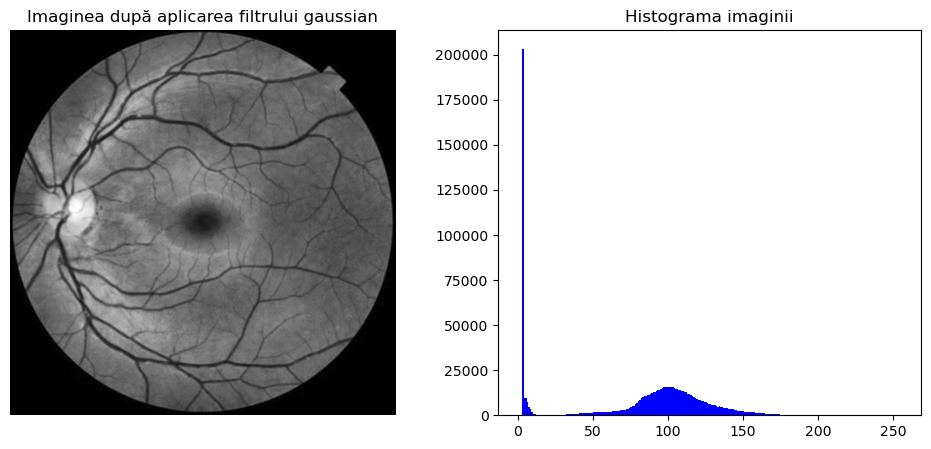

In [22]:
imgBlur = cv2.GaussianBlur(preprocessed_image, (5, 5), 4) 

plt.figure(figsize=(12, 5))

# afișarea imaginii după aplicarea filtrului gaussian
plt.subplot(1, 2, 1)
plt.imshow(imgBlur, cmap='gray')
plt.title("Imaginea după aplicarea filtrului gaussian")
plt.axis('off')  # Eliminarea axelor

# afișarea histogramei imaginii
plt.subplot(1, 2, 2)
plt.hist(imgBlur.ravel(),256,[0, 256], color='blue')
plt.title("Histograma imaginii")
plt.show()

Funcția morphological_filters() aplică transformări morfologice ca dilatarea si eroziunea. 
Se creează un element structurant liniar (un dreptunghi de 30x1 pixeli) care este rotit la 8 unghiuri (0°, 45°, 90°,.. 315). 
Acesta este un șablon de formă dreptunghiulară (o linie orizontală) care va fi folosit pentru operații morfologice (dilatare și eroziune). Dimensiunea (structuring_element_length, 1) înseamnă că elementul are o lungime de structuring_element_length și o lățime de 1 pixel, fiind astfel o linie orizontală.

Se creează o matrice de rotație care va roti elementul de structurare în jurul punctului (structuring_element_length / 2, 0), adică în mijlocul elementului pe axa X și la începutul lui pe axa Y. Această rotație este efectuată la unghiul angle, specificat în bucla principală. Factorul de scalare este 1, ceea ce înseamnă că dimensiunea elementului nu se va schimba. Această matrice va fi folosită pentru a roti linia orizontală (elementul de structurare) la unghiul dorit.

Se folosește transformarea de rotație pentru a aplica rotația definită în rotation_matrix asupra elementului de structurare line_element. Noua dimensiune a imaginii rotite este setată la (structuring_element_length, structuring_element_length), oferindu-i o zonă pătrată în care să încapă rotația completă. Rezultatul este un element de structurare rotit, care va evidenția liniile din imagine la unghiul specificat.

Se aplică dilatarea pe imaginea imgBlur folosind elementul de structurare rotated_line_element. Dilatarea face ca regiunile luminoase (pixelii albi) să fie extinse în jurul structurilor liniilor detectate în direcția dată de rotated_line_element. Acest proces ajută la evidențierea liniilor subțiri și a contururilor de-a lungul unghiului rotit.
Se aplică eroziunea pe imaginea dilatată. Eroziunea reduce pixelii albi în jurul structurilor, restrângând liniile extinse anterior și eliminând zgomotul. Eroziunea este folosită aici pentru a aduce structurile înapoi la dimensiunea originală după dilatare, dar păstrând doar liniile proeminente în direcția specificată.

După eroziune, se calculează diferența între imaginea careia i se aplica dilatarea si eroziunea și imaginea de dupa filtrarea gaussiana.
Răspunsurile obținute pentru fiecare unghi sunt combinate prin insumare, rezultând o imagine finală returnata de aceasta functie.

In [39]:
def morphological_filters(imgBlur):
     orientations = [0, 45, 90, 135, 180, 225, 270, 315]
     structuring_element_length = 30

     morphological_responses = []

     for angle in orientations:

         # se creează un element de structurare liniar de dimensiune (structuring_element_length x 1)
        line_element = cv2.getStructuringElement(cv2.MORPH_RECT, (structuring_element_length, 1))
         # se creează o matrice de rotație pentru elementul de structurare, pentru unghiul curent
        rotation_matrix = cv2.getRotationMatrix2D((structuring_element_length / 2, 0), angle, 1)
        rotated_line_element = cv2.warpAffine(line_element, rotation_matrix, (structuring_element_length, structuring_element_length))

        dilated = cv2.dilate(imgBlur, rotated_line_element)
        eroded = cv2.erode(dilated, rotated_line_element)
    
        response = cv2.subtract(eroded, imgBlur)
        # response = eroded - imgBlur
        morphological_responses.append(response)
     return response

Se afiseaza imaginea rezultata in urma aplicarii filtrelor morfologice - dilatare si eroziune, precum si histograma acesteia.

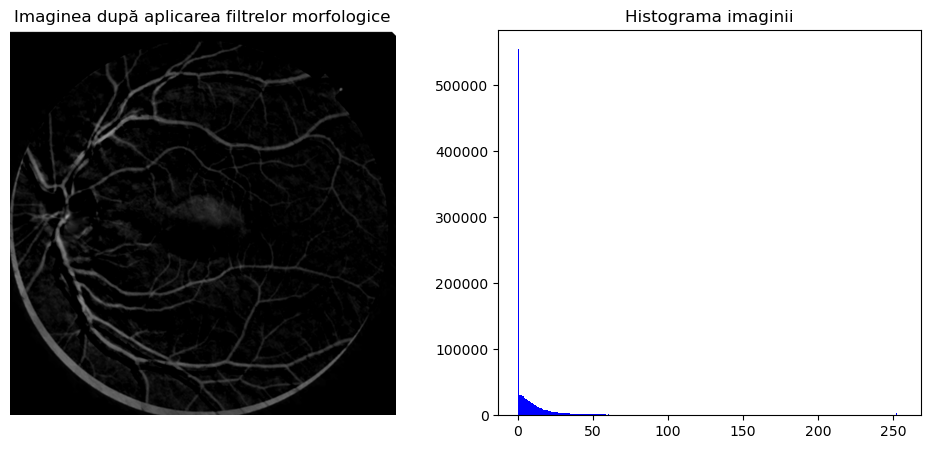

In [40]:
morfFilters_img = morphological_filters(imgBlur)

plt.figure(figsize=(12, 5))

# afișarea imaginii după aplicarea filtrelor morfologice
plt.subplot(1, 2, 1)
plt.imshow(morfFilters_img, cmap='gray')
plt.title("Imaginea după aplicarea filtrelor morfologice")
plt.axis('off')  # Eliminarea axelor

# afișarea histogramei imaginii
plt.subplot(1, 2, 2)
plt.hist(morfFilters_img.ravel(),256,[0, 256], color='blue')
plt.title("Histograma imaginii")
plt.show()



Se creeaza o functie utilizata pentru binarizare, functie ce foloseste metoda Threshold.
Se aplică cv2.threshold cu THRESH_BINARY pentru a transforma pixelii mai mari decât pragul ales  în 255 (alb) și pe cei mai mici în 0 (negru). Valorea minima in cazul functiei THRESH_BINARY este implicit 0.
Funcția returnează imaginea binarizată, care contine doar valori de 0 sau 255.

In [41]:

def binarization_function(morfFilters_img):
    
   ret1,thresh1 = cv2.threshold(morfFilters_img, 25, 255, cv2.THRESH_BINARY)
   return thresh1


Se apeleaza functia binarization_function() prin intermediul variabilei morfFilters_img, iar apoi se afiseaza imaginea finala, binarizata.

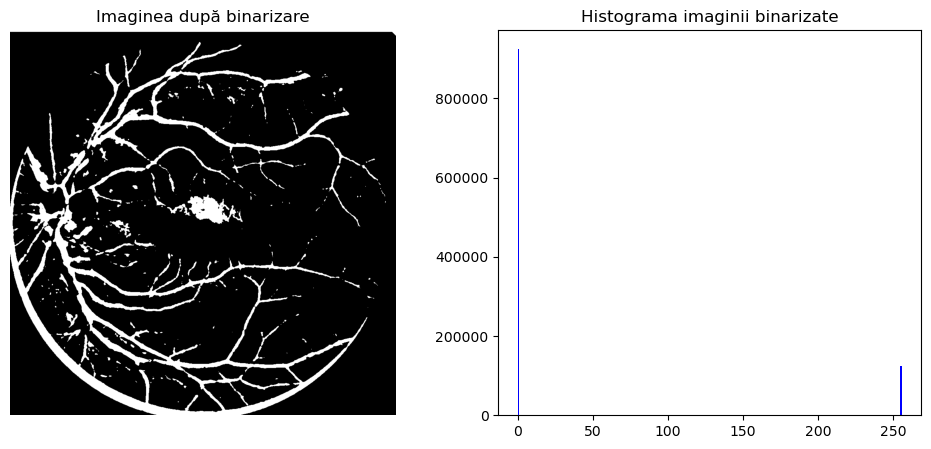

In [42]:
# Conversia imaginii la float32 înainte de normalizare
morfFilters_img = morfFilters_img.astype(np.float32)

# Normalizează rezultatul pentru a fi în intervalul 0-255
morfFilters_img = cv2.normalize(morfFilters_img, None, 0, 255, cv2.NORM_MINMAX)

# Converteste la tipul de date int pe 8 biți
morfFilters_img = np.uint8(morfFilters_img)

binary_img = binarization_function(morfFilters_img)
plt.figure(figsize=(12, 5))

# afișarea imaginii după aplicarea filtrelor morfologice
plt.subplot(1, 2, 1)
plt.imshow(binary_img, cmap='gray')
plt.title("Imaginea după binarizare")
plt.axis('off')  # Eliminarea axelor

# afișarea histogramei imaginii
plt.subplot(1, 2, 2)
plt.hist(binary_img.ravel(), 256, [0, 256], color='blue')
plt.title("Histograma imaginii binarizate")
plt.show()


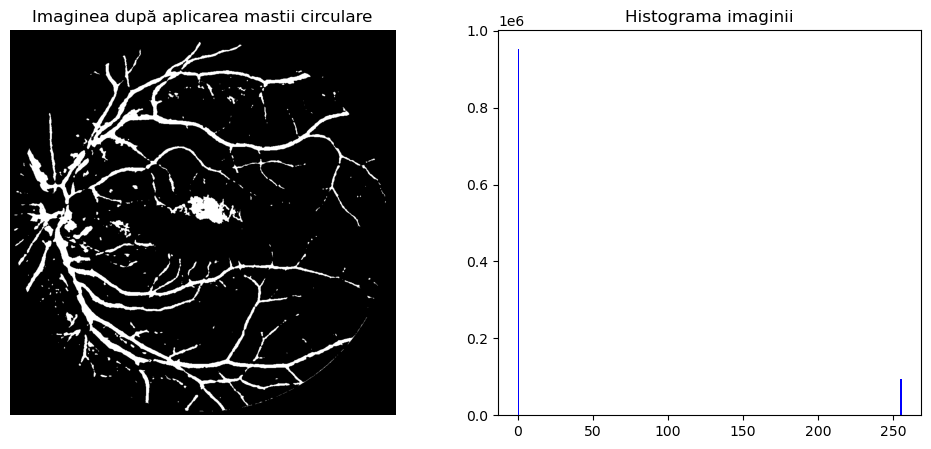

In [43]:
# Dimensiunea imaginii
height, width = binary_img.shape

# Crearea unei imagini goale cu aceleași dimensiuni ca imaginea originală
mask = np.zeros((height, width), dtype=np.uint8)

# Definirea centrului și a razei pentru masca circulară
center = (width // 2, height // 2)  
radius = min(width, height) // 2 - 10  

# Crearea măștii circulare
cv2.circle(mask, center, radius, (255), thickness=-1)  # Desenează un cerc plin

# Aplicarea măștii pe imaginea originală
masked_image = cv2.bitwise_and(binary_img, binary_img, mask=mask)

plt.figure(figsize=(12, 5)) 
plt.subplot(1, 2, 1)
plt.imshow(masked_image, cmap='gray')
plt.title("Imaginea după aplicarea mastii circulare")
plt.axis('off')  # Eliminarea axelmasked_imageor
plt.subplot(1, 2, 2)
plt.hist(masked_image.ravel(),256,[0, 256], color='blue')
plt.title("Histograma imaginii")
plt.show()
